#第五章　誤差逆伝播法のまとめ

##計算グラフ
計算の過程を図で可視化したもの。今回の章は複雑なものを扱うのでこれでわかりやすくしている。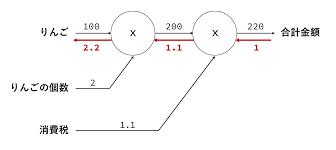

計算グラフの特徴は、『局所的な計算』を伝播することによって最終的な結果を得ることができる点にある。

##順伝播と逆伝播
上記の計算グラフを左から行うものを**順伝播**、右から行うものを**逆伝播**という。

##合成関数と連鎖律
合成関数とは、複数の関数によって構成される関数のこと。

例　($z=(x+y)^2$)

　そして連鎖律はこれの微分についての性質であり、次のように定義される。

 　　ある関数が合成関数で表される場合、その合成関数の微分は、合成関数を構成するそれぞれの関数の微分の積によってあらわせる。(これを**連鎖律の原理**という)

##逆伝播
####加算ノードと乗算ノード

計算グラフにおける計算の操作のこと



##加算ノードの逆伝播
ここでは $z=x+y$を対象にする。
これの微分は

$\frac{∂ z}{∂ x}=1$

 $\frac{∂ z}{∂ y}=1$

よって上流から伝わった加算ノードをそのまま流す。


##加算ノードの逆伝播
ここでは $z=xy$を対象にする。

これは以下のようになる。https___qiita-image-store.s3.amazonaws.com_0_169589_98367463-bf18-b889-c4ce-d37390958f0c.avif

これらを用いたものが以下のグラフになる。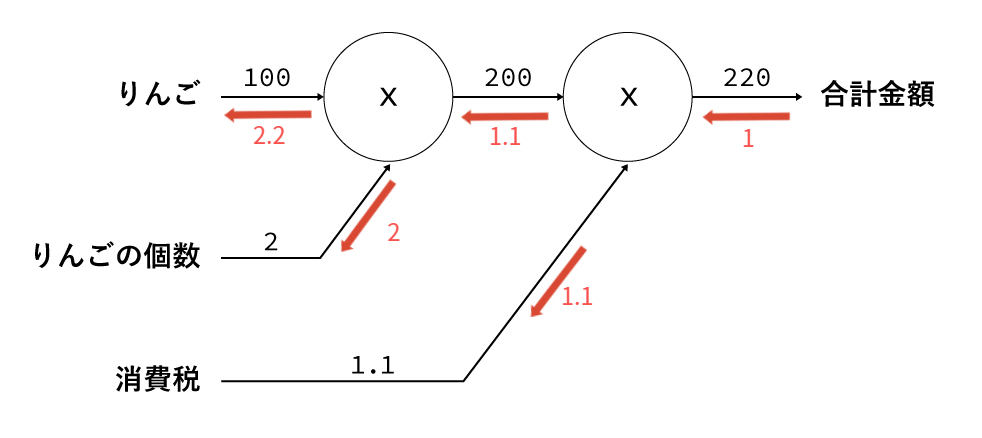

##乗算レイヤの実装
先ほどの乗算ノードのことである。

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

##加算レイヤの実装

In [3]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

そしてこれらを用い、以下のグラフの計算を実装する。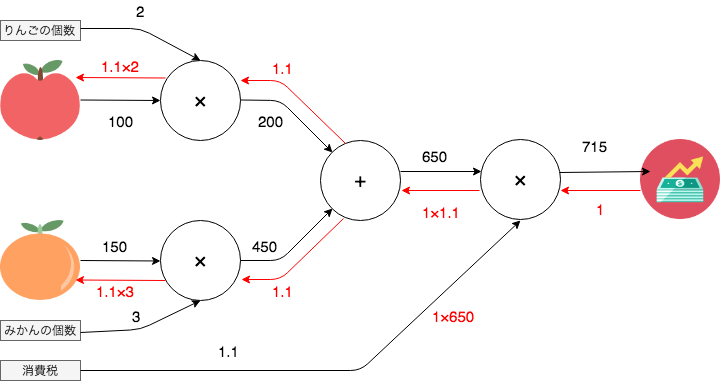

In [4]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print(int(price))
print(int(dapple_num), dapple, int(dorange), int(dorange_num), dtax)

715
110 2.2 3 165 650


#活性化関数レイヤの実装


##ReLUレイヤ
活性化関数として使われるReLU(Recetified Linear Unit)は以下の式で表される。

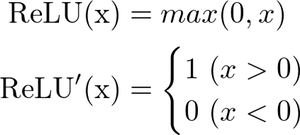

In [6]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

        #これは回路におけるスイッチのような役割を持つ

##Sigmoidレイヤの実装
式は以下のようにあらわされる

$y-\frac{1}{1+exp(-x)}$

In [5]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

#Affine/Softmaxレイヤの実装

##Affineレイヤの実装
ニューラルネットワークの順伝播では、重み付き信号の総和の計算に行列の積計算を用いた。ニューラルネットワークの順伝播で行う行列の積計算を、幾何学の分野では「アフィン変換」と呼ぶ。そのため、ここではアフィン変換の処理を「Affineレイヤ」として実装する。

In [7]:
import numpy as np
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

##Softmax-with-Lossレイヤの実装


In [8]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

##数値微分と誤差逆伝播法の使い分け
###数値微分

メリット　実装がシンプル

デメリット　計算に時間がかかる

###誤差逆伝播法

メリット　処理に時間がかからない

デメリット　実装が長くなる



基本的には誤差逆伝播法が用いられるが、これはコードが長くなるので実装にミスがある可能性がある。それを防ぐために数値微分で同じ実装を行い、結果を比較するというやり方がある。これを**勾配確認(gradient check)**という。

###本章で学んだこと
- 計算グラフを用いれば、計算過程を視覚的に把握することができる。
- 計算グラフのノードは局所的な計算によって構成される。局所的な計算が全体の計算を構成する。
- 計算グラフの順伝播は、通常の計算を行う。一方、計算グラフの逆伝播によって、各ノードの微分を求めることができる。
- ニューラルネットワークの構成用要素をレイヤとして実装することで、勾配の計算を効率的に求めることができる(**誤差逆伝播法**)。
- 数値微分と誤差逆伝播法の結果を比較することで、誤差逆伝播法の実装に偏りがないことを確認できる(**勾配確認**)。